# Model

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# !unzip -qq /content/drive/MyDrive/dataset.zip

In [8]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [9]:
!pip install -qq open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.8 MB/s eta 0:00:00


In [10]:
import torch 
from PIL import Image, ImageEnhance
from torchvision import transforms
import open_clip
from torchvision.transforms import InterpolationMode

In [11]:
import open_clip
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32-quickgelu', 'openai'),
 ('ViT-B-32-quickgelu', 'laion400m_e31'),
 ('ViT-B-32-quickgelu', 'laion400m_e32'),
 ('ViT-B-16', 'openai'),
 ('ViT-B-16', 'laion400m_e31'),
 ('ViT-B-16', 'laion400m_e32'),
 ('ViT-B-16', 'laion2b_s34b_b88k'),
 ('ViT-B-16-plus-240', 'laion400m_e31'),
 ('ViT-B-16-plus-240', 'laion400m_e32'),
 ('ViT-L-14', 'openai'),
 ('ViT-L-14', 'laion400m_e31'),
 ('ViT-L-14', 'laion400m_e32'),
 ('ViT-L-14', 'laion2b_s32b_b82k'),
 ('ViT-L-14-336', 'openai'),
 ('ViT-H-14', 'laion2b_s32b_

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, _, preprocess = open_clip.create_model_and_transforms('coca_ViT-L-14', pretrained='mscoco_finetuned_laion2b_s13b_b90k')
model.cuda()

CoCa(
  (text): TextTransformer(
    (token_embedding): Embedding(49408, 768)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_final): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(1

In [13]:
def load_image(image_path, preprocess_func):
    img = Image.open(image_path)
    return preprocess_func(img)

def load_images(filepaths, preprocess_func):
    images = [load_image(fp, preprocess_func) for fp in filepaths]
    return torch.stack(images)

def get_all_embeddings_batched(filepaths, model, preprocess_func, batch_size=32):
    num_images = len(filepaths)
    all_embeddings = []

    for start_idx in range(0, num_images, batch_size):
        end_idx = start_idx + batch_size
        batch_filepaths = filepaths[start_idx:end_idx]
        batch_images = load_images(batch_filepaths, preprocess_func)
        with torch.no_grad():
            batch_embeddings = model.encode_image(batch_images.to(device))
        all_embeddings.extend(batch_embeddings.cpu().numpy())

    return np.array(all_embeddings)


In [14]:
train_filepaths = glob.glob('/content/Gallery_sameCamera/**/*.jpg', recursive=True)
test_filepaths = glob.glob('/content/Gallory_diffCamera/**/*.jpg', recursive=True)
query_filepaths = glob.glob('/content/query/*.jpg', recursive=True)
len(train_filepaths),len(test_filepaths),len(query_filepaths)

(6504, 3871, 9)

In [15]:
query_embeddings = get_all_embeddings_batched(query_filepaths, model, preprocess)
train_embeddings = get_all_embeddings_batched(train_filepaths, model, preprocess)
test_embeddings = get_all_embeddings_batched(test_filepaths, model, preprocess)

# Predict

In [16]:
def extract_image_info(filepath):
    img = cv2.imread(filepath)
    h, w, c = img.shape
    img_class = os.path.basename(os.path.dirname(filepath)).split('.')[-1]
    return [w, h, img_class]

In [17]:
df = pd.DataFrame(train_filepaths, columns=['filepath'])

In [18]:
df[['W', 'H', 'DogID']] = pd.DataFrame(df['filepath'].apply(extract_image_info).to_list())

In [19]:
NUM_CLASSES = len(df['DogID'].unique())

In [20]:
test_embeddings.shape

(3871, 768)

In [21]:
query_embeddings[0]


array([ 2.28986219e-02,  7.31108058e-03,  4.06153005e-04, -6.78016152e-03,
       -1.51008554e-02, -6.10091072e-03, -1.42561243e-04,  2.17293855e-02,
        8.12449772e-03, -4.73837554e-02,  7.50547647e-03, -2.56182943e-02,
       -2.91898903e-02, -4.25053947e-03,  6.10643160e-03,  2.95041618e-03,
       -1.56988837e-02, -2.08456535e-02,  4.08158153e-02, -3.77893634e-02,
       -1.84093285e-02,  1.92564145e-01, -1.39199486e-02, -1.10766152e-02,
        1.20287323e-02, -3.36976685e-02,  6.52138889e-02, -2.94567887e-02,
        1.10259205e-02,  1.35045946e-02,  1.24370456e-02, -4.15600836e-02,
        2.18258351e-02, -3.43461484e-02, -1.98861994e-02, -5.00472263e-02,
       -6.62883278e-03, -6.29809452e-04, -3.64966281e-02,  4.76151286e-03,
       -1.32521680e-02,  1.42949121e-02, -2.03669574e-02,  2.73908582e-02,
       -2.61544660e-02, -2.51556691e-02, -1.27723925e-02, -4.34865151e-03,
       -4.18095402e-02, -9.53645911e-03,  2.02018041e-02,  9.82122403e-03,
       -1.68573752e-04, -

In [22]:
print(query_embeddings.shape)

(9, 768)


In [23]:
import matplotlib.pyplot as plt

def plot_distance_distribution(distances):
    flattened_distances = distances.flatten()
    plt.hist(flattened_distances, bins=50)
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Euclidean Distances')
    plt.show()

In [24]:
from sklearn.preprocessing import normalize

def euclidean_distance_matrix(x, y):
    x_square_sum = np.sum(x ** 2, axis=1)[:, np.newaxis]
    y_square_sum = np.sum(y ** 2, axis=1)
    xy_product_sum = np.dot(x, y.T)
    return np.sqrt(x_square_sum + y_square_sum - 2 * xy_product_sum)

<ipython-input-24-5e3e8ed98dea>:7: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x_square_sum + y_square_sum - 2 * xy_product_sum)


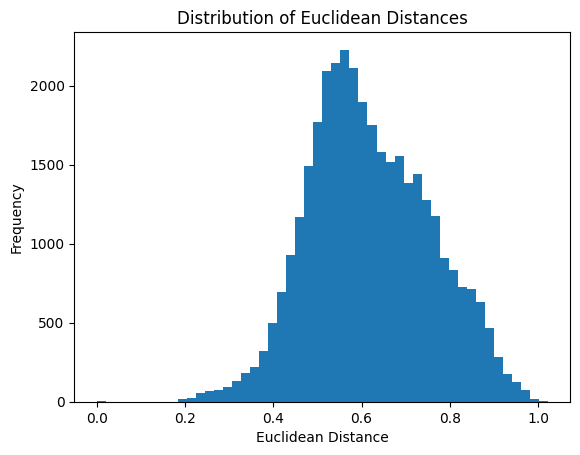

In [25]:
from sklearn.preprocessing import normalize

query_embeddings_normalized = normalize(query_embeddings, axis=1)
test_embeddings_normalized = normalize(test_embeddings, axis=1)

distances_normalized = euclidean_distance_matrix(test_embeddings_normalized, query_embeddings_normalized)

plot_distance_distribution(distances_normalized)

In [26]:
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

def visualize_closest_images_cosine_similarity(query_embeddings, test_embeddings, query_filepaths, test_filepaths, n_closest):
    similarities = cosine_similarity(query_embeddings, test_embeddings)
    fig, axes = plt.subplots(len(query_filepaths), n_closest + 1, figsize=(3 * (n_closest + 1), 3 * len(query_filepaths)))

    for i, query_filepath in enumerate(query_filepaths):
        query_image = Image.open(query_filepath)
        query_image.thumbnail((100, 100), Image.ANTIALIAS)
        axes[i, 0].imshow(query_image)
        axes[i, 0].set_title("Query Image")
        axes[i, 0].axis("off")

        closest_indices = np.argpartition(similarities[i], -n_closest)[-n_closest:]
        sorted_closest_indices = closest_indices[np.argsort(-similarities[i, closest_indices])]

        for j, closest_index in enumerate(sorted_closest_indices):
            test_image = Image.open(test_filepaths[closest_index])
            test_image.thumbnail((100, 100), Image.ANTIALIAS)
            axes[i, j + 1].imshow(test_image)
            axes[i, j + 1].set_title(f"Closest {j + 1}\nSimilarity: {similarities[i, closest_index]:.2f}")
            axes[i, j + 1].axis("off")

    plt.tight_layout()
    plt.show()


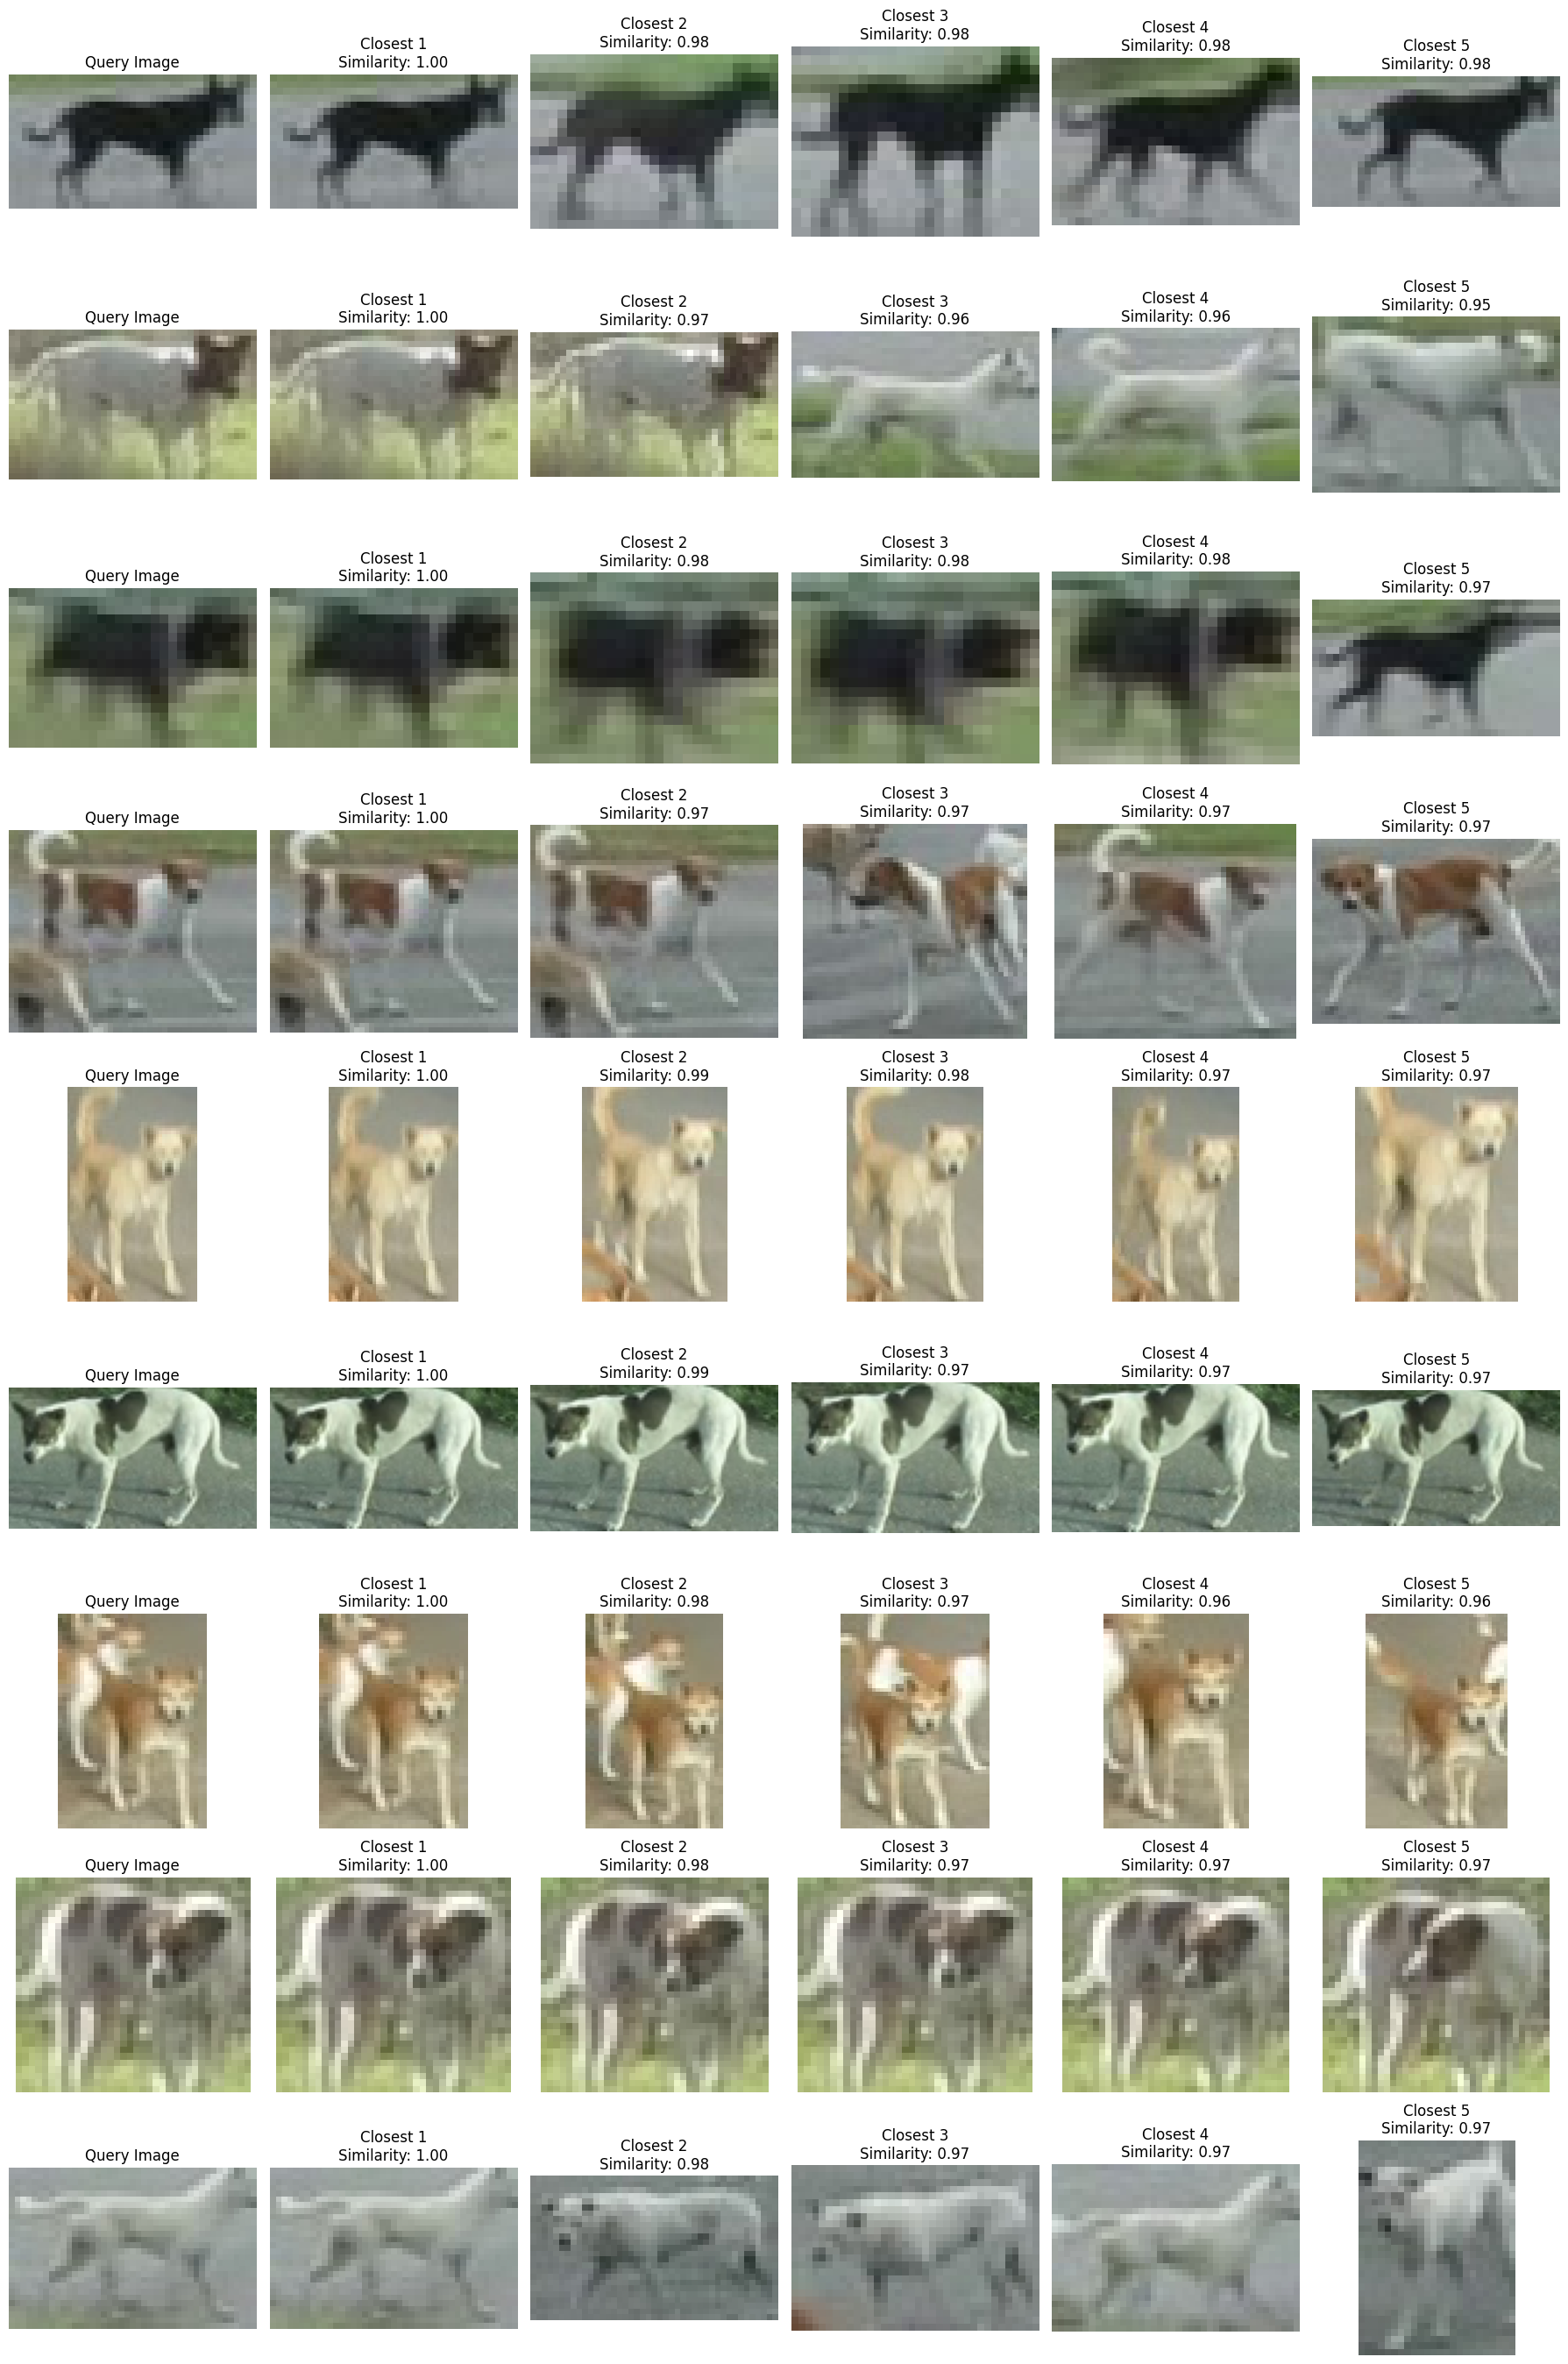

In [27]:
n_closest = 5
visualize_closest_images_cosine_similarity(query_embeddings, test_embeddings, query_filepaths, test_filepaths, n_closest)


# Train images

In [28]:
from sklearn.manifold import TSNE
import time

n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(train_embeddings) #Here

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6504 samples in 0.003s...
[t-SNE] Computed neighbors for 6504 samples in 2.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6504
[t-SNE] Computed conditional probabilities for sample 2000 / 6504
[t-SNE] Computed conditional probabilities for sample 3000 / 6504
[t-SNE] Computed conditional probabilities for sample 4000 / 6504
[t-SNE] Computed conditional probabilities for sample 5000 / 6504
[t-SNE] Computed conditional probabilities for sample 6000 / 6504
[t-SNE] Computed conditional probabilities for sample 6504 / 6504
[t-SNE] Mean sigma: 0.103514
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.796341
[t-SNE] KL divergence after 1000 iterations: 0.796506
t-SNE done! Time elapsed: 49.97557330131531 seconds


In [29]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()
    
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()

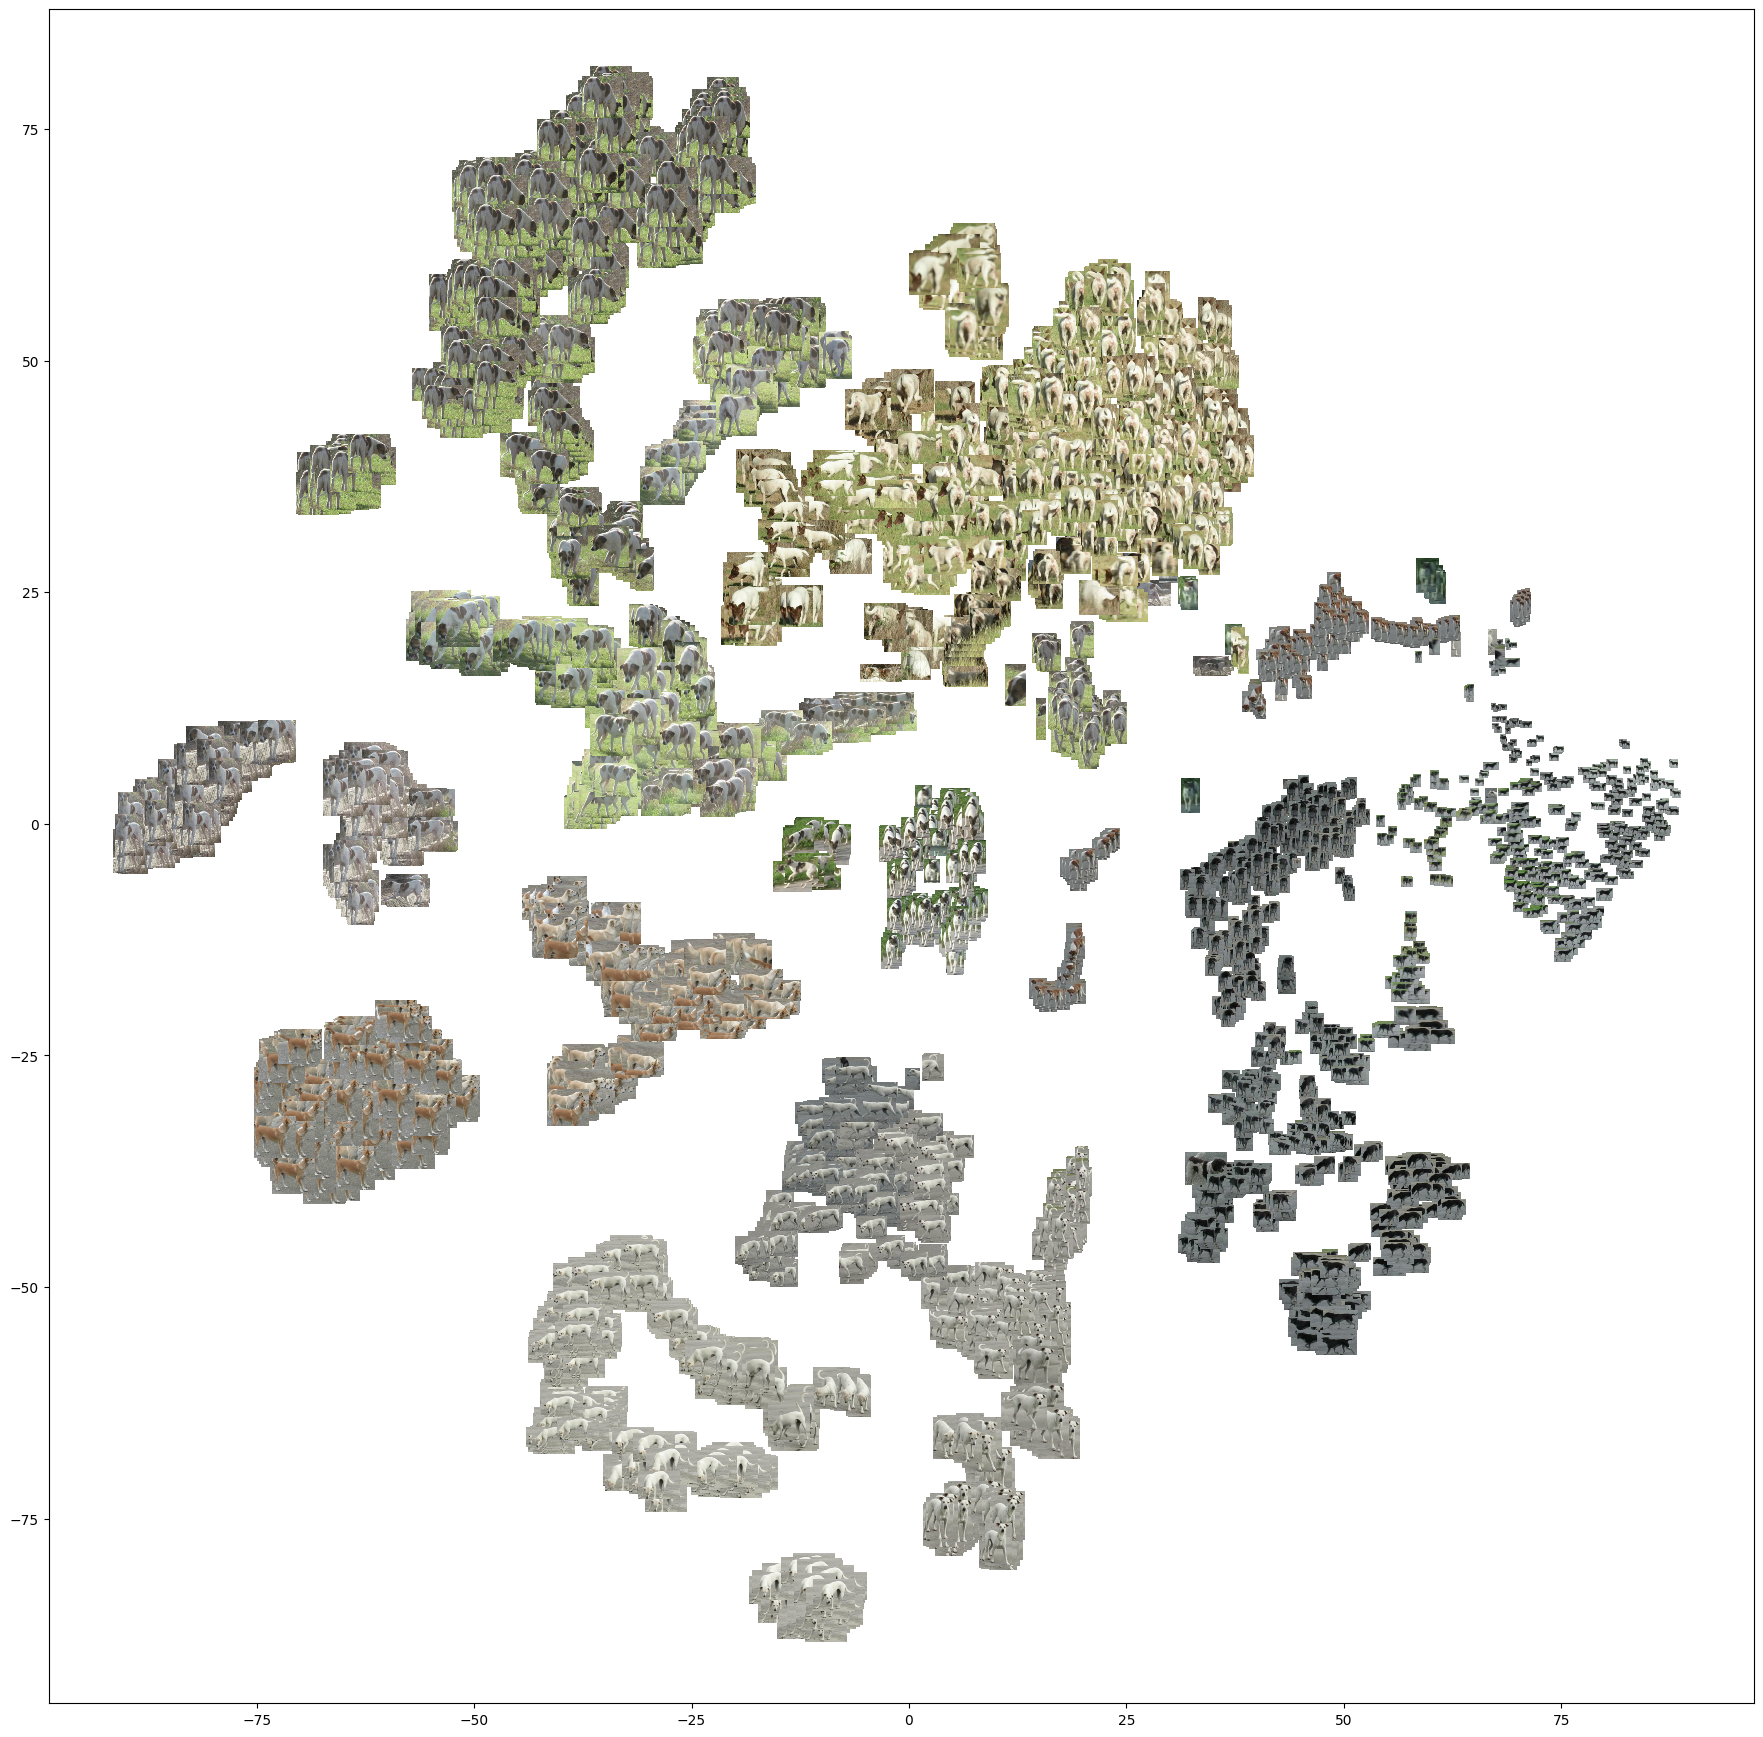

In [30]:
x = tsne_results[:, 0]
y = tsne_results[:, 1]

show_tsne(x, y, train_filepaths)

# Test images

In [31]:
n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(test_embeddings) #Here

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3871 samples in 0.002s...
[t-SNE] Computed neighbors for 3871 samples in 0.934s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3871
[t-SNE] Computed conditional probabilities for sample 2000 / 3871
[t-SNE] Computed conditional probabilities for sample 3000 / 3871
[t-SNE] Computed conditional probabilities for sample 3871 / 3871
[t-SNE] Mean sigma: 0.120653
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.883369
[t-SNE] KL divergence after 1000 iterations: 0.805751
t-SNE done! Time elapsed: 27.45979952812195 seconds


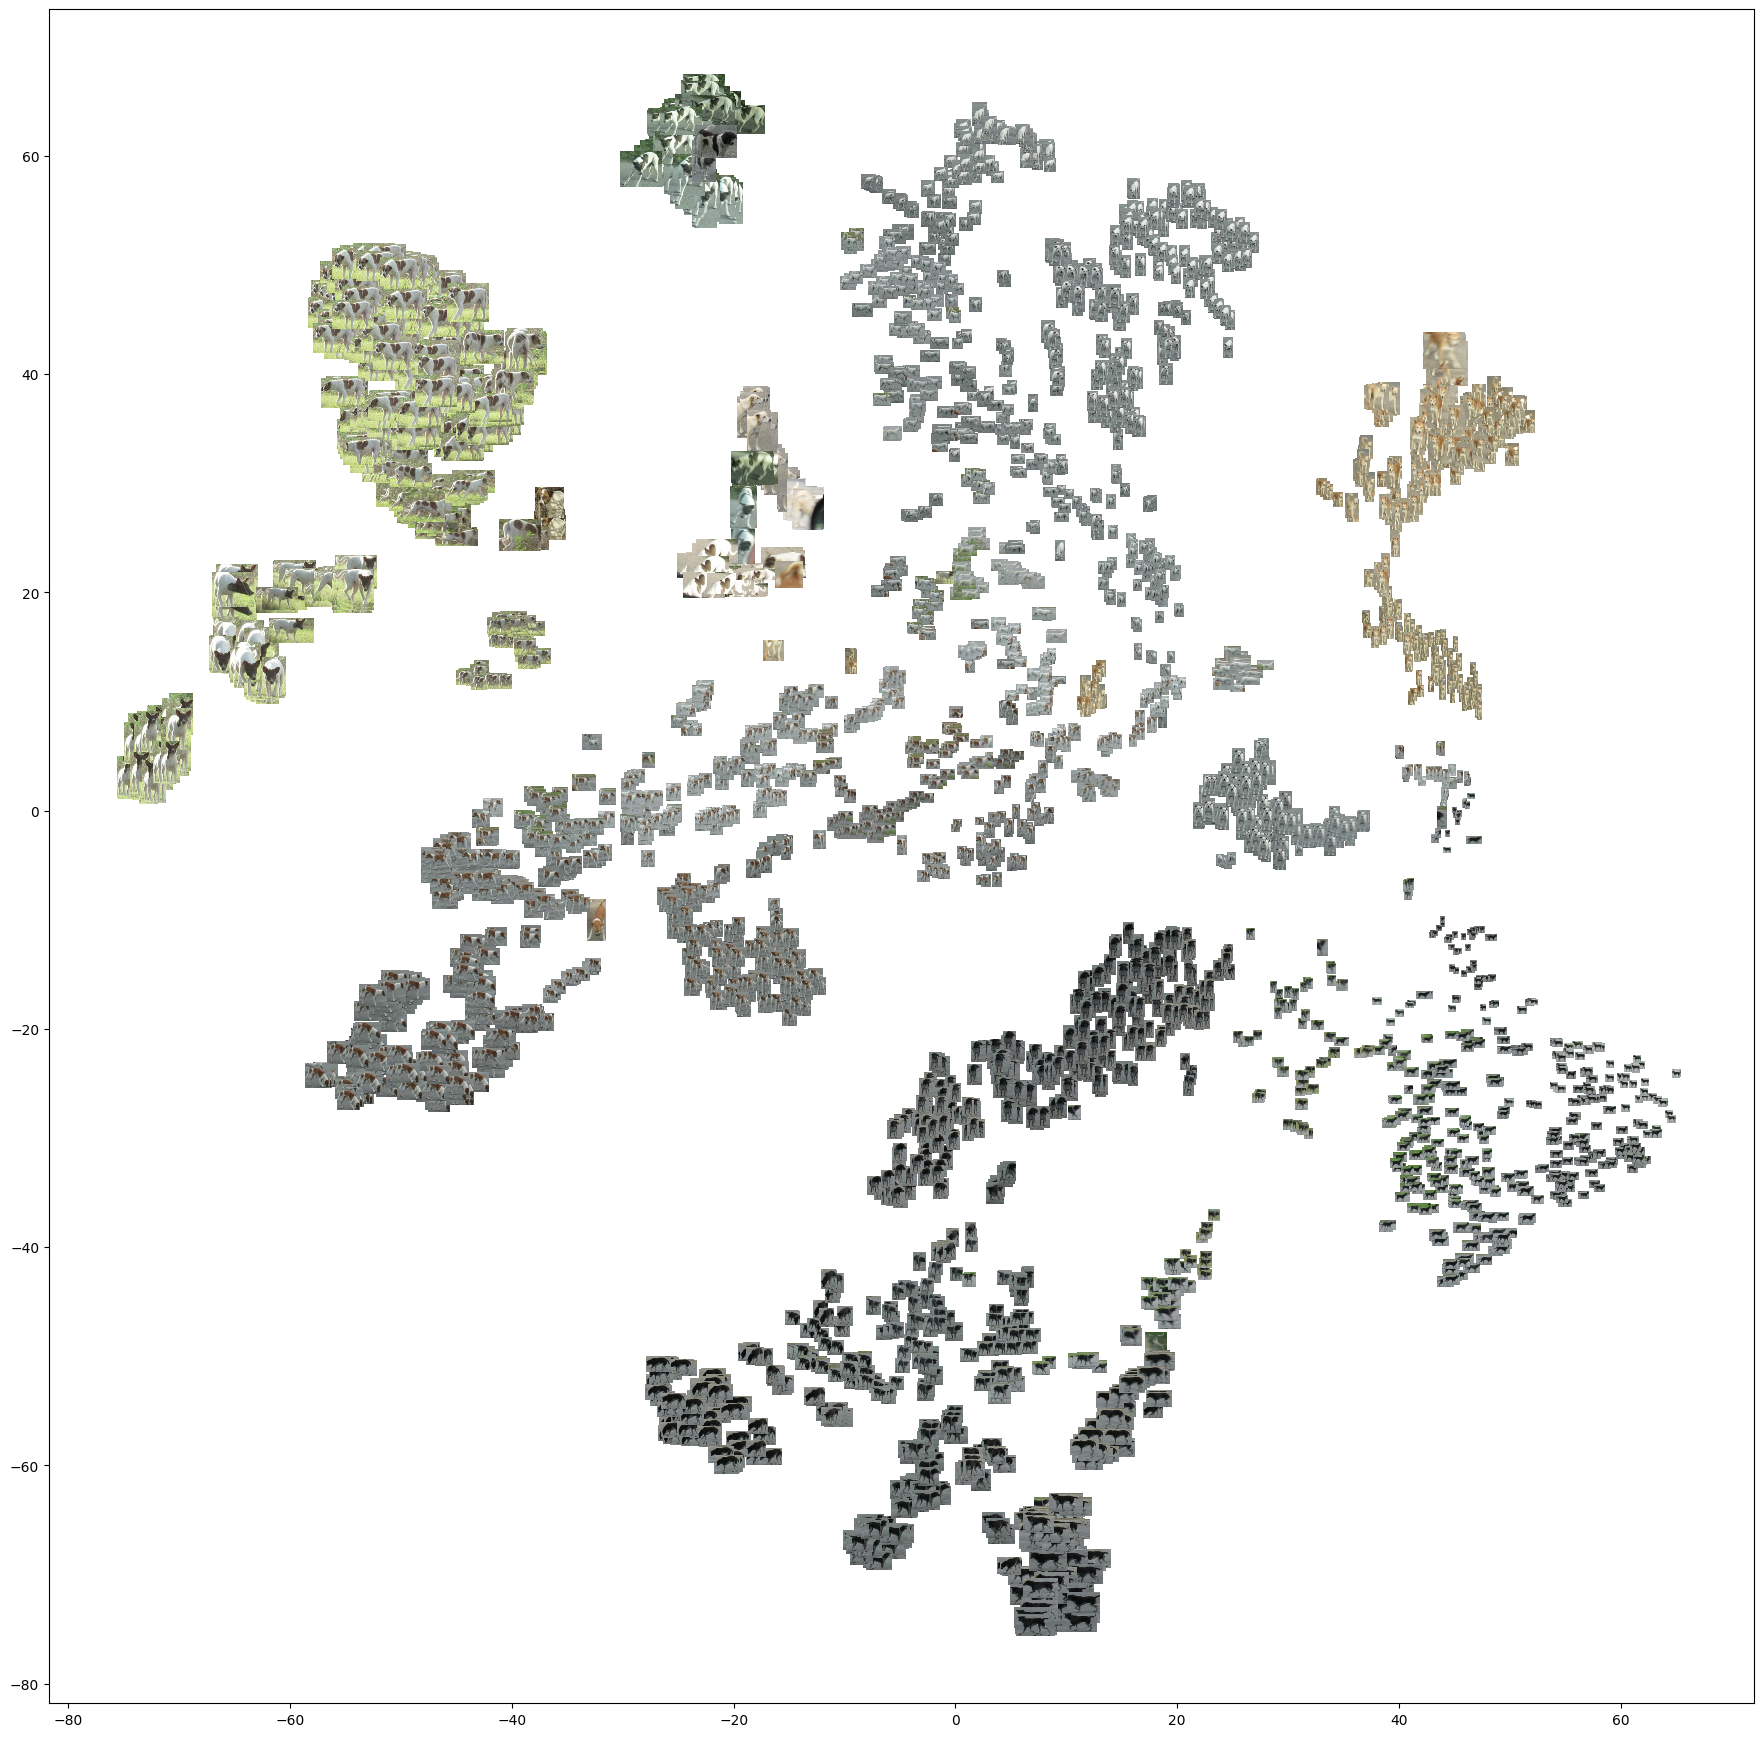

In [32]:
x = tsne_results[:, 0]
y = tsne_results[:, 1]

show_tsne(x, y, test_filepaths)

# Visualization by Euclidean distance

In [33]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_closest_images(query_embeddings, test_embeddings, query_filepaths, test_filepaths, n_closest):
    distances = euclidean_distance_matrix(query_embeddings, test_embeddings)
    fig, axes = plt.subplots(len(query_filepaths), n_closest + 1, figsize=(3 * (n_closest + 1), 3 * len(query_filepaths)))

    for i, query_filepath in enumerate(query_filepaths):
        query_image = Image.open(query_filepath)
        query_image.thumbnail((100, 100), Image.ANTIALIAS)
        axes[i, 0].imshow(query_image)
        axes[i, 0].set_title("Query Image")
        axes[i, 0].axis("off")

        closest_indices = np.argpartition(distances[i], n_closest)[:n_closest]
        sorted_closest_indices = closest_indices[np.argsort(distances[i, closest_indices])]

        for j, closest_index in enumerate(sorted_closest_indices):
            test_image = Image.open(test_filepaths[closest_index])
            test_image.thumbnail((100, 100), Image.ANTIALIAS)
            axes[i, j + 1].imshow(test_image)
            axes[i, j + 1].set_title(f"Closest {j + 1}\nDistance: {distances[i, closest_index]:.2f}")
            axes[i, j + 1].axis("off")
plt.tight_layout()
plt.show()

           


<Figure size 640x480 with 0 Axes>

<ipython-input-24-5e3e8ed98dea>:7: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x_square_sum + y_square_sum - 2 * xy_product_sum)


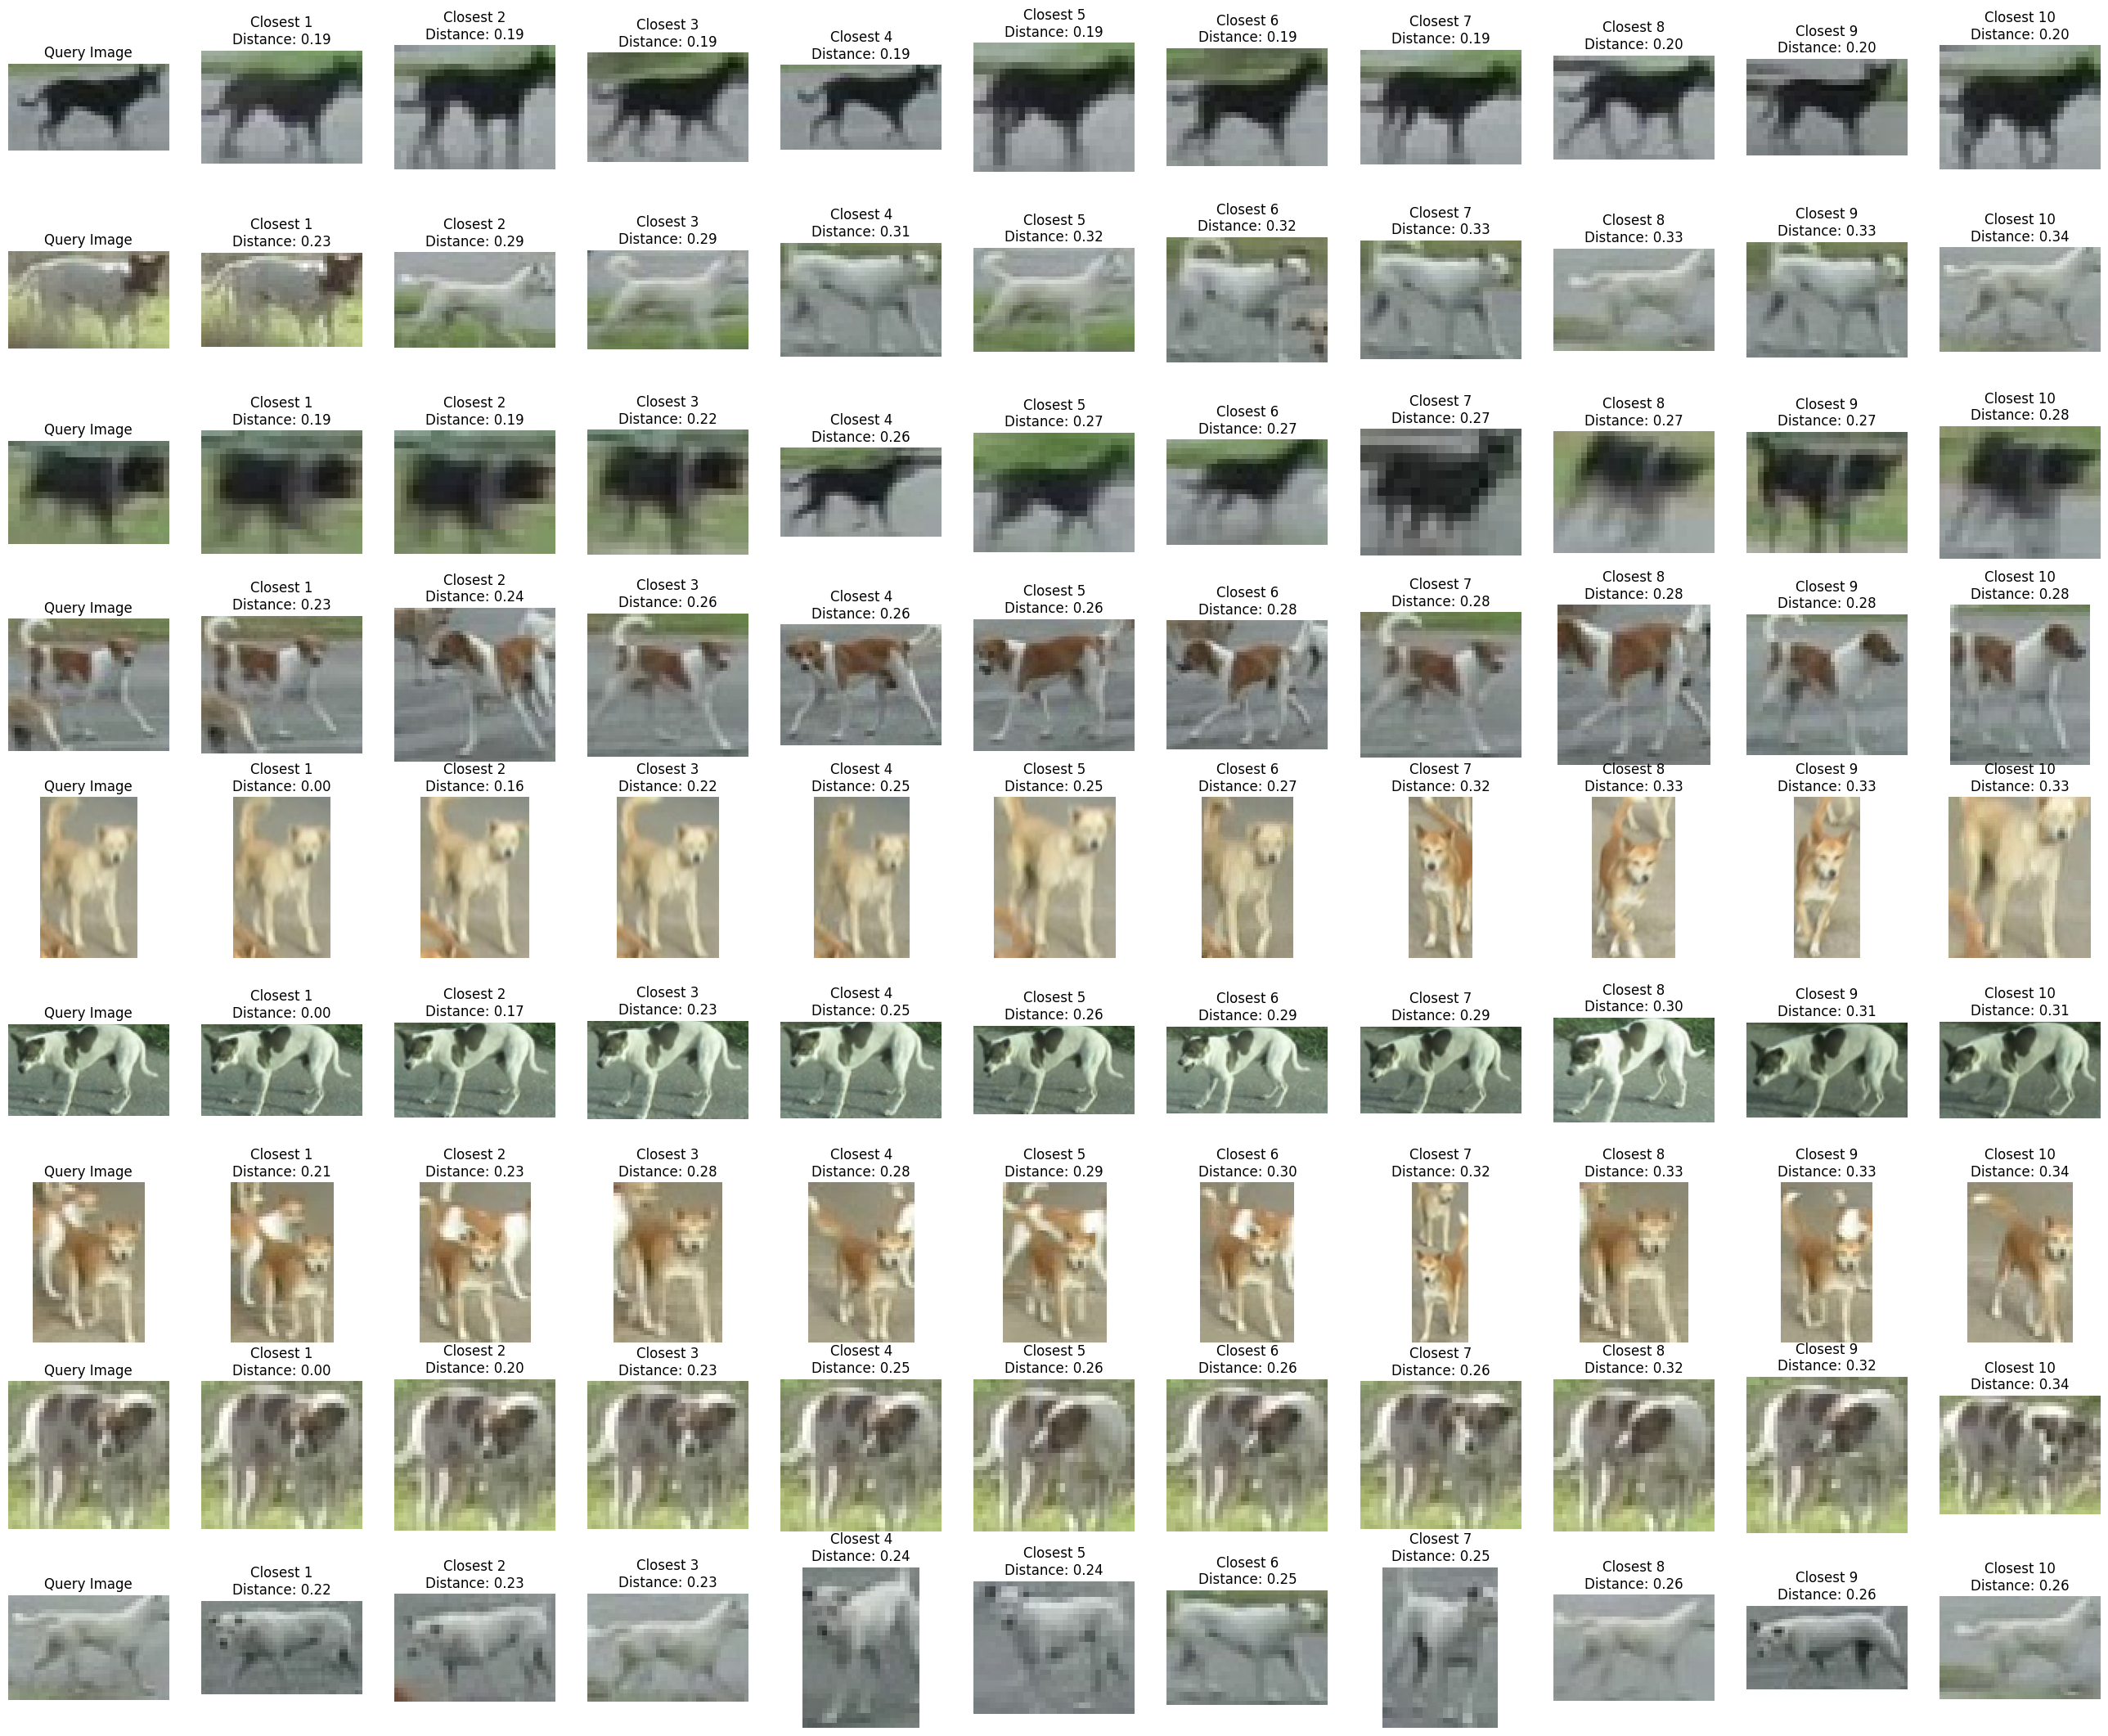

In [34]:
visualize_closest_images(query_embeddings, test_embeddings, query_filepaths, test_filepaths, n_closest=10)

In [35]:
df_test = pd.DataFrame(test_filepaths, columns=['filepath'])

In [36]:
def extract_image_id(row):
    filepath = row['filepath']
    img_class = os.path.basename(os.path.dirname(filepath)).split('.')[-1]
    return img_class

In [40]:
df_test['True_DogID'] = df_test.apply(extract_image_id, axis=1)
train_filepaths = df['filepath'].tolist()
train_dog_ids = df['DogID'].tolist()
test_filepaths = df_test['filepath'].tolist()
true_labels = df_test['True_DogID'].tolist()

similarity_matrix = cosine_similarity(test_embeddings)

In [38]:
similarity_matrix = cosine_similarity(test_embeddings)

In [41]:
from sklearn.metrics import roc_curve, auc, accuracy_score

def get_binary_labels(true_labels):
    num_samples = len(true_labels)
    binary_labels = np.zeros((num_samples, num_samples), dtype=bool)
    for i in range(num_samples):
        for j in range(num_samples):
            binary_labels[i, j] = true_labels[i] == true_labels[j]
    return binary_labels

binary_labels = get_binary_labels(true_labels)
binary_labels_flat = binary_labels.flatten()

thresholds = np.linspace(0, 1, num=200)
best_threshold = 0
best_acc = 0

for threshold in thresholds:
    pred_labels_flat = similarity_matrix.flatten() > threshold
    acc = accuracy_score(binary_labels_flat, pred_labels_flat)
    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold

print("Best threshold:", best_threshold)
print("Best accuracy:", best_acc)


Best threshold: 0.9195979899497487
Best accuracy: 0.8514408186355615


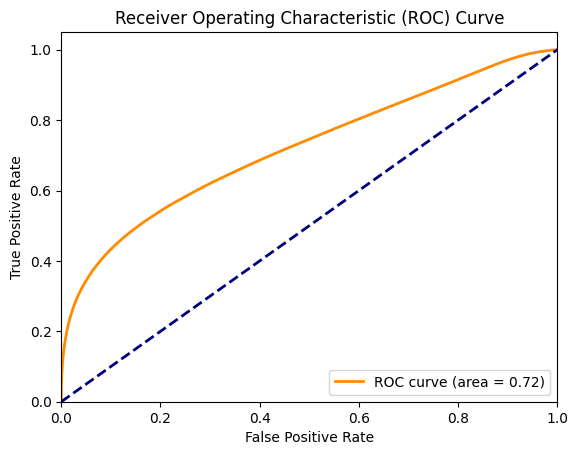

In [42]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(binary_labels_flat, similarity_matrix.flatten())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [44]:
def average_precision(ranked_labels, true_label, rank):
    correct_label_count = 0
    ap_sum = 0
    for i, label in enumerate(ranked_labels[:rank]):
        if label == true_label:
            correct_label_count += 1
            ap_sum += correct_label_count / (i + 1)
    return ap_sum / correct_label_count if correct_label_count > 0 else 0

def mean_average_precision(similarity_matrix, true_labels, ranks):
    num_queries = len(true_labels)
    map_values = []
    
    for rank in ranks:
        ap_values = []
        for query_idx in range(num_queries):
            query_similarities = similarity_matrix[query_idx]
            sorted_indices = np.argsort(-query_similarities)  # Sort in descending order
            ranked_labels = [true_labels[i] for i in sorted_indices]
            ap = average_precision(ranked_labels, true_labels[query_idx], rank)
            ap_values.append(ap)
        map_values.append(np.mean(ap_values))
    return map_values

ranks = [1, 5, 10, 50, 1000]
map_values = mean_average_precision(similarity_matrix, df_test['True_DogID'], ranks)

for rank, map_value in zip(ranks, map_values):
    print(f"MAP@{rank}: {map_value:.4f}")


MAP@1: 1.0000
MAP@5: 0.9969
MAP@10: 0.9910
MAP@50: 0.9582
MAP@1000: 0.7340


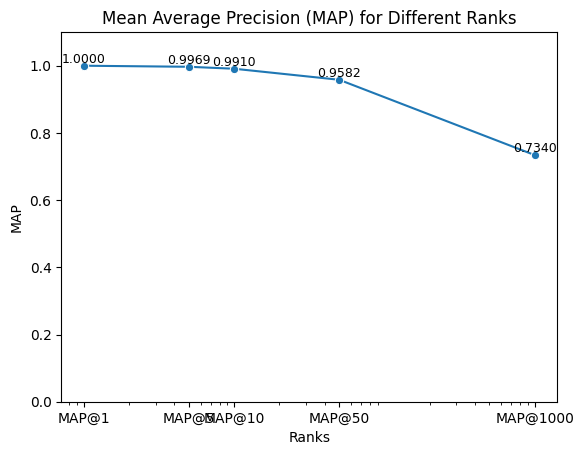

In [66]:
data = pd.DataFrame({'Ranks': ranks, 'MAP': map_values})
plt.figure()
sns.lineplot(data=data, x='Ranks', y='MAP', marker='o')

# Set the y-axis limits to be between 0 and 1
plt.ylim(0, 1.1)

# Set the x-axis to logarithmic scale
plt.xscale('log')

# Customize the x-axis ticks and labels
plt.xticks(ranks, [f'MAP@{rank}' for rank in ranks])

# Add the title
plt.title('Mean Average Precision (MAP) for Different Ranks')

# Add the MAP values as labels on the plot
for i, value in enumerate(map_values):
    plt.text(ranks[i], value + 0.01, f"{value:.4f}", ha='center', fontsize=9)

